# Instalación de librerias.

In [ ]:
!pip install boto3
!pip install tensorflow
!pip install tensorflow --upgrade

     |████████████████████████████████| 133kB 7.6MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 7.6MB 12.5MB/s 
     |████████████████████████████████| 143kB 43.0MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
     |████████████████████████████████| 133kB 8.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.26.5
    Uninstalling urllib3-1.26.5:
      Successfully uninstalled urllib3-1.26.5
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)


# Activo la libreria de drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Verificacion tecnica del sistema.



In [ ]:
from platform import python_version
import tensorflow as tf

print("Version de python: " + python_version())
print("Version de tensorflow: " + tf.__version__)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Version de python: 3.7.10
Version de tensorflow: 2.5.0
Tue Jun  1 03:48:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# Carga del dataset.

In [ ]:
from glob import glob

# path_train = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-train-rgb/'
# train_filenames=(glob(path_train+'*.tfrecords'))
# train_filenames
train_filenames = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-mineria-tfrecord/dataset-mineria-train-rgb.tfrecords'

In [ ]:
path_test = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-test-rgb/'
test_filenames=(glob(path_test+'*.tfrecords'))
test_filenames
#test_filenames = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-test-rgb.tfrecords'

['/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica-tfrecord/dataset-estadistica-test-rgb/dataset-estadistica-test-rgb.tfrecords-part-0.tfrecords']

In [ ]:
import os
import pandas as pd

pathClases = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica/train/rgb'

classes = os.listdir(pathClases)

aux = []
for _idx, _valor in enumerate(classes):
    Class = _valor
    label = (classes.index(_valor))
    aux.append([Class, label])
    
csv = pd.DataFrame(aux, columns=['Class','label'])
csv.head(10)

,Class,label
0,double_plant,0
1,drydown,1
2,endrow,2
3,planter_skip,3
4,nutrient_deficiency,4
5,storm_damage,5
6,water,6
7,waterway,7
8,weed_cluster,8


In [ ]:
#Tamaño de las imágenes en los archivos TFRecord
IMAGE_SIZE=[512,512]
CLASSES=list(csv['Class'])
print(CLASSES)
NO_OF_CLASSES=len(CLASSES)
NO_OF_CLASSES

['double_plant', 'drydown', 'endrow', 'planter_skip', 'nutrient_deficiency', 'storm_damage', 'water', 'waterway', 'weed_cluster']


9

In [ ]:
# Funciones utilies.
import math
from matplotlib import pyplot as plt
import tensorflow as tf

AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convertir la imagen en flotantes en el rango [0, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # tamaño explícito necesario para el TPU
    return image

def read_tfrecord(example):
    features={
            "image_raw": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64),}
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example['image_raw'])
    label = tf.cast(example['label'], tf.int32)
    return image, label

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct
                                
def load_dataset(filenames,shuffle,BATCH_SIZE,repeat=False):
    # Leer desde TFRecords. Para un rendimiento óptimo, lea de varios
    # Archivos TFRecord a la vez y establecer la opción experimental_deterministic = False
    # para permitir optimizaciones que alteren el orden.
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.prefetch(AUTO)
    dataset = dataset.shuffle(shuffle)
    if(repeat):
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def display_batch_of_images(databatch, predictions=None):
    """Esto funcionará con:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-cuadrado: esto eliminará los datos que no encajen en un cuadrado o rectángulo.
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # tamaño y espaciado
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # mostrar
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # fórmula mágica probada para trabajar de 1x1 a 10x10 imágenes
        subplot = display_one(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #diseño
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # cadena binaria en este caso, se trata de cadenas de identificación de imágenes.
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # Si no hay etiquetas, sólo los ID de las imágenes, devuelve None para las etiquetas (este es el caso de los datos de prueba)
    return numpy_images, numpy_labels

def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

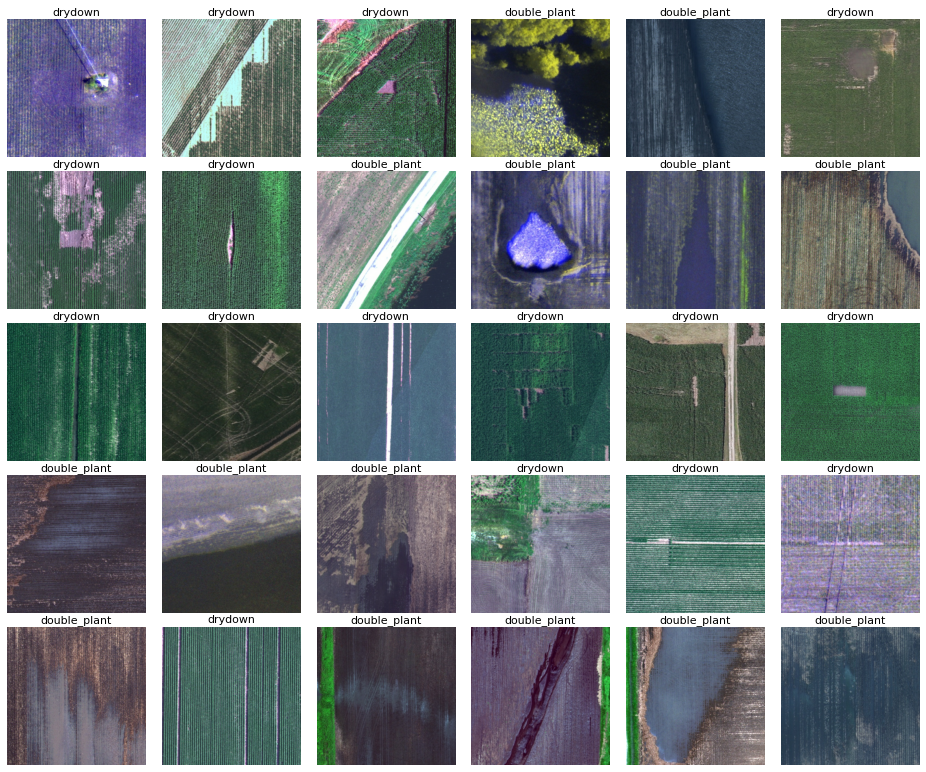

In [ ]:
#Mostrar algunas imágenes del conjunto de datos de entrenamiento.
d=load_dataset(train_filenames,5000,30)
train_batch=iter(d)
display_batch_of_images(next(train_batch))

In [ ]:
import keras.backend as K

K.clear_session()

def build_model(num_classes, img_size=512):
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.MobileNet(include_top=False, input_tensor=input, weights="imagenet")

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.3
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)
 
    model.summary()
    # Compile
    model = tf.keras.Model(input, output, name="ResNet50")
    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    return model

In [ ]:
BATCH_SIZE = 32
shuffle=5000
train_dataset=load_dataset(train_filenames,shuffle,BATCH_SIZE,True)
test_dataset=load_dataset(test_filenames,int(shuffle*0.5),BATCH_SIZE)

In [ ]:
num_imagenes = glob(pathClases + '/*/*')

num_classes = 9
#num_images = len(num_imagenes)
num_images = 70500

model = build_model(num_classes)

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 256, 256, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 256, 256, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 256, 256, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 256, 256, 32)      128       
_________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('/content/drive/MyDrive/AgricultureVisión/models/resultados/pesos/weights_MobileNet_full.hdf5',
                             monitor='val_loss',
                             save_best_only=True)

callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    batch_size=32, epochs=25,
                    steps_per_epoch=math.ceil(num_images/32),
                    callbacks=callbacks_list)

Epoch 1/25
2204/2204 [==============================] - 1747s 778ms/step - loss: 0.4243 - sparse_categorical_accuracy: 0.8779 - val_loss: 5.5165 - val_sparse_categorical_accuracy: 0.1778
Epoch 2/25
2204/2204 [==============================] - 1726s 783ms/step - loss: 0.3141 - sparse_categorical_accuracy: 0.9065 - val_loss: 8.0466 - val_sparse_categorical_accuracy: 0.1333
Epoch 3/25
2204/2204 [==============================] - 1734s 787ms/step - loss: 0.2764 - sparse_categorical_accuracy: 0.9164 - val_loss: 5.2547 - val_sparse_categorical_accuracy: 0.2156
Epoch 4/25
2204/2204 [==============================] - 1728s 784ms/step - loss: 0.2459 - sparse_categorical_accuracy: 0.9223 - val_loss: 6.9776 - val_sparse_categorical_accuracy: 0.2200
Epoch 5/25
2204/2204 [==============================] - 1732s 786ms/step - loss: 0.2298 - sparse_categorical_accuracy: 0.9288 - val_loss: 4.1195 - val_sparse_categorical_accuracy: 0.2222
Epoch 6/25
2204/2204 [==============================] - 1733s 786

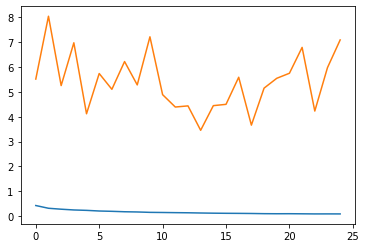

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.savefig("/content/drive/MyDrive/AgricultureVisión/models/resultados/loss_vs_valLoss/MobileNet_epo_25_Full.jpg")

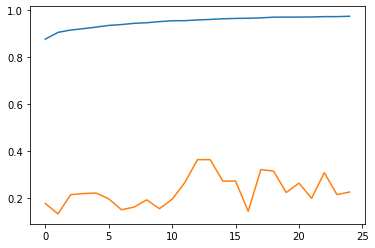

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

#plt.savefig("/content/drive/MyDrive/AgricultureVisión/models/resultados/accuracy_vs_valAccuracy/MobileNet_epo_25_Full.jpg")

In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/AgricultureVisión/models/model_MobileNet_epo_25_Full.h5')

In [ ]:
from keras.models import load_model

path_model = '/content/drive/MyDrive/AgricultureVisión/models/model_MobileNet_epo_50.h5'

model = load_model(path_model)
model.load_weights('/content/drive/MyDrive/AgricultureVisión/models/resultados/pesos/weights_MobileNet_full.hdf5')

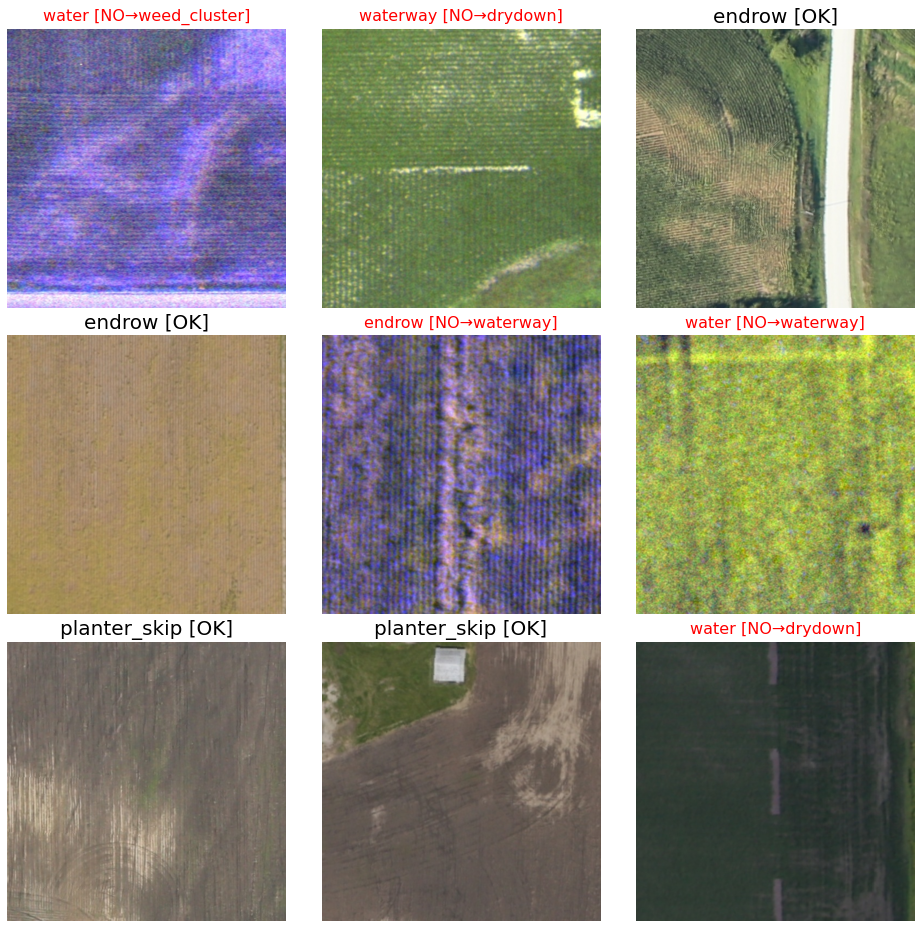

In [ ]:
#Display predicted images in test set
numero_imagenes_ = 10
valid=load_dataset(test_filenames,5000,numero_imagenes_)
valid=next(iter(valid))
result=model.predict(valid[0])
display_batch_of_images(valid,predictions=tf.argmax(result,axis=1))